In [10]:
import os
import sys
import random
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM, Dense

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error

In [12]:
import cv2
import requests
from io import BytesIO
from PIL import Image

In [13]:
import ipywidgets as widgets
from IPython.display import display

In [14]:
plt.style.use('fivethirtyeight')

In [15]:
df = pd.read_csv("solar_wind (1).csv")
print("Solar wind data shape:", df.shape)
print(df.head())

Solar wind data shape: (8392320, 17)
    period        timedelta  bx_gse  by_gse  bz_gse  theta_gse  phi_gse  \
0  train_a  0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   
1  train_a  0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   
2  train_a  0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   
3  train_a  0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   
4  train_a  0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   

   bx_gsm  by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density   speed  \
0   -5.55    3.00    1.25      11.09   153.37  6.80     1.53  383.92   
1   -5.58    3.16    1.17      10.10   151.91  6.83     1.69  381.79   
2   -5.15    3.66    0.85       7.87   146.04  6.77     1.97  389.11   
3   -5.20    3.68    0.68       6.17   146.17  6.74     1.97  389.11   
4   -5.12    3.68    0.49       4.62   145.72  6.65     1.77  384.26   

   temperature source  
0     110237.0     ac  
1     123825.0     ac  
2      

In [16]:
# Fill missing numeric values with mean for defined columns
numeric_columns = ['bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'bx_gsm',
                   'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gse', 'phi_gsm', 'bt']
for column in numeric_columns:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [17]:
# Fill missing values in 'source' column with forward fill
df['source'].fillna(method='ffill', inplace=True)
print("Null values after imputation:")
print(df.isnull().sum())

Null values after imputation:
period              0
timedelta           0
bx_gse              0
by_gse              0
bz_gse              0
theta_gse           0
phi_gse             0
bx_gsm              0
by_gsm              0
bz_gsm              0
theta_gsm           0
phi_gsm             0
bt                  0
density        684890
speed          689555
temperature    811768
source              0
dtype: int64


In [18]:
# Load labels and sunspots datasets
dst = pd.read_csv("labels.csv")
sunspots = pd.read_csv("sunspots.csv")

In [19]:
# Convert timedelta columns to proper timedelta format
df['timedelta'] = pd.to_timedelta(df['timedelta'])
dst['timedelta'] = pd.to_timedelta(dst['timedelta'])
sunspots['timedelta'] = pd.to_timedelta(sunspots['timedelta'])

In [20]:
# Set multi-index for each dataframe using 'period' and 'timedelta'
df.set_index(["period", "timedelta"], inplace=True)
dst.set_index(["period", "timedelta"], inplace=True)
sunspots.set_index(["period", "timedelta"], inplace=True)

print("Solar wind shape:", df.shape)
print("Sunspots shape:", sunspots.shape)
print("Labels shape:", dst.shape)

Solar wind shape: (8392320, 15)
Sunspots shape: (192, 1)
Labels shape: (139872, 1)


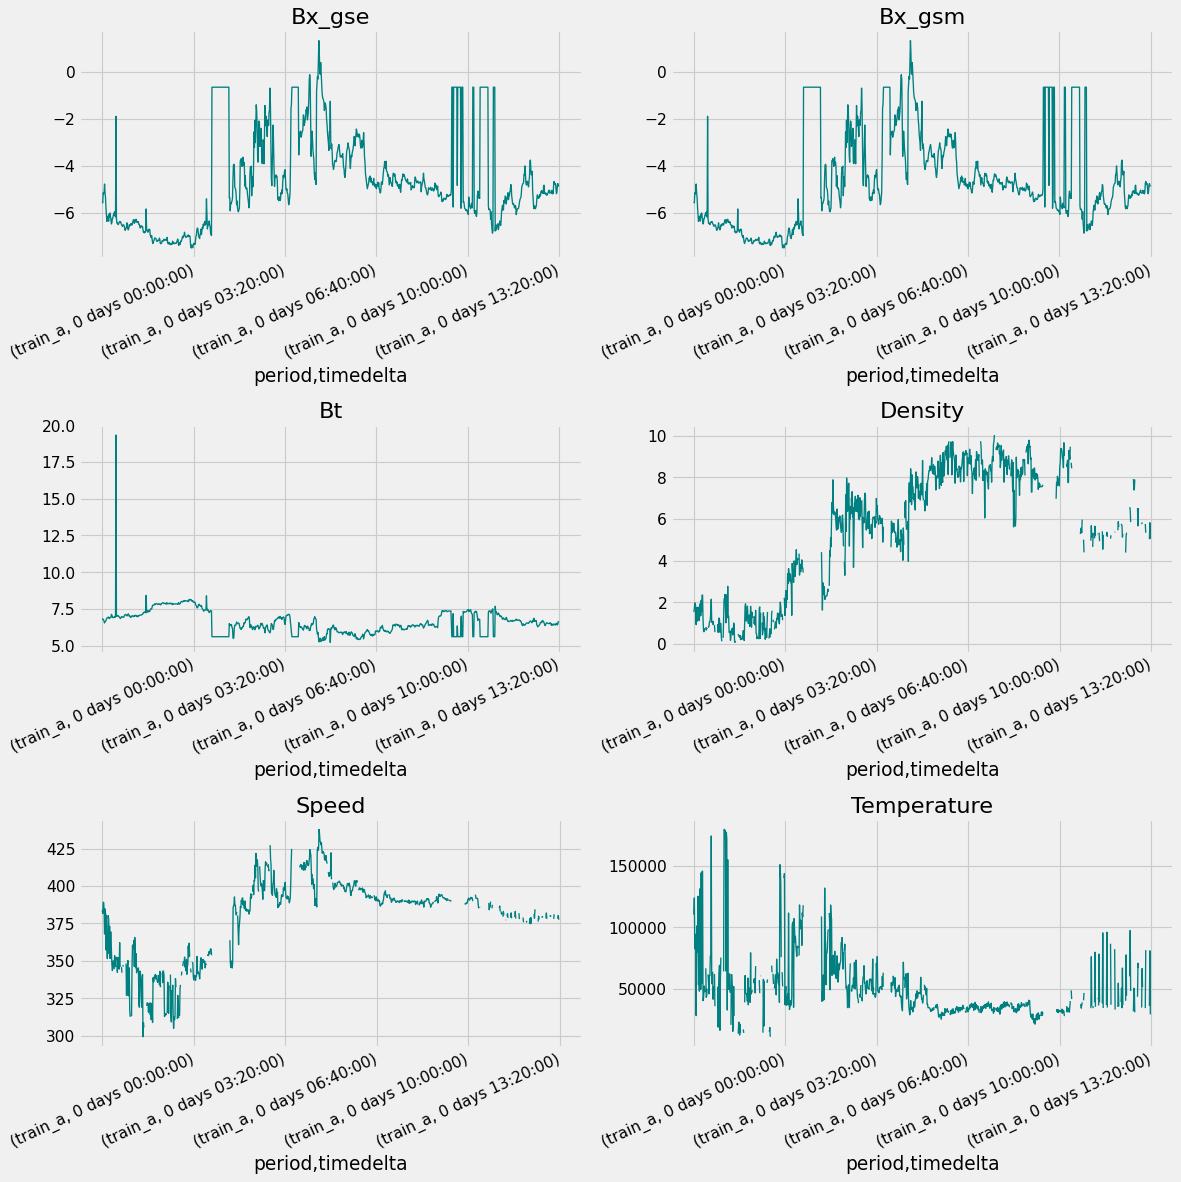

In [21]:
# Visualize key features and inspect correlations between numeric columns.

# %% [code]
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25, color='teal', lw=1.2
        )
    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()
    plt.show()

cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(df[cols_to_plot].iloc[:1000])

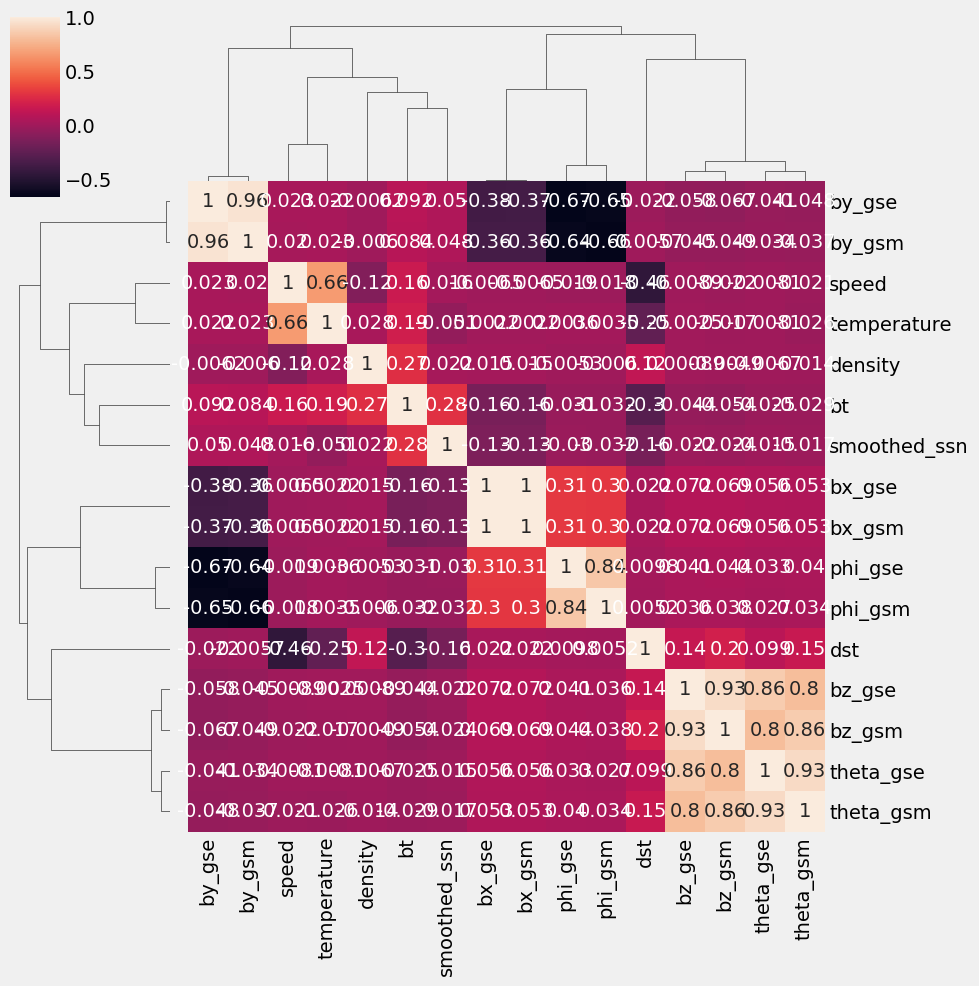

In [22]:
# Join datasets for correlation analysis
joined = df.join(sunspots).join(dst).fillna(method="ffill")
numeric_cols = joined.select_dtypes(include=[np.number])
sns.clustermap(numeric_cols.corr(), annot=True)
plt.show()

In [23]:
# Define solar wind features to be used for modeling
SOLAR_WIND_FEATURES = [
    "bt", "temperature", "bx_gse", "by_gse", "bz_gse", "speed", "density",
]

XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES] +
    [col + "_std" for col in SOLAR_WIND_FEATURES] +
    ["smoothed_ssn"]
)

def impute_features(feature_df):
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    numeric_cols = feature_df.select_dtypes(include=[np.number])
    feature_df[numeric_cols.columns] = numeric_cols.interpolate()
    return feature_df

def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    feature_df = feature_df.select_dtypes(include=[np.number])
    for col in feature_df.columns:
        feature_df[col] = pd.to_numeric(feature_df[col], errors='coerce')
    feature_df = feature_df.fillna(feature_df.mean())
    agged = feature_df.groupby(["period", feature_df.index.get_level_values(1).floor("H")]).agg(aggs)
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged

def preprocess_features(df, sunspots, scaler=None, subset=None):
    if subset:
        df = df[subset]
    hourly_features = aggregate_hourly(df).join(sunspots)
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)
    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )
    imputed = impute_features(normalized)
    return imputed, scaler

features, scaler = preprocess_features(df, sunspots, subset=SOLAR_WIND_FEATURES)
print("Features shape:", features.shape)
assert (features.isna().sum() == 0).all()

Features shape: (139872, 15)


In [24]:
# Process labels: Shift the dst column to create t0 and t1 columns
YCOLS = ["t0", "t1"]
def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period")["dst"].shift(-1)
    y.columns = YCOLS
    if len(y.columns) != len(YCOLS):
        raise ValueError("Length of YCOLS does not match the number of columns in y")
    return y

labels = process_labels(dst)
data = labels.join(features)

In [25]:
# Split the data into training, testing, and validation sets per period
def get_train_test_val(data, test_per_period, val_per_period):
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    val = interim.groupby("period").tail(val_per_period)
    train = interim[~interim.index.isin(val.index)]
    if train.empty or test.empty or val.empty:
        raise ValueError("Training, testing, or validation set is empty")
    return train, test, val

train, test, val = get_train_test_val(data, test_per_period=6000, val_per_period=3000)

In [26]:
# Update XCOLS for time series model input
XCOLS = [
    "bt_mean", "temperature_mean", "bx_gse_mean", "by_gse_mean", "bz_gse_mean",
    "speed_mean", "density_mean", "bt_std", "temperature_std", "bx_gse_std",
    "by_gse_std", "bz_gse_std", "speed_std", "density_std", "smoothed_ssn",
]

data_config = {
    "timesteps": 32,
    "batch_size": 32,
    "solar_wind_subset": SOLAR_WIND_FEATURES
}

def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]
    for _, period_df in df.groupby("period"):
        if len(period_df) <= timesteps:
            continue  # Skip periods with insufficient data
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]
        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )
        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)
    if dataset is None:
        raise ValueError("No period had enough data for the specified timesteps")
    return dataset

train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")

Number of train batches: 3523
Number of validation batches: 276


In [27]:
# Build and compile the LSTM model
timesteps = data_config["timesteps"]
num_features = len(XCOLS)

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(timesteps, num_features)),
    Dense(len(YCOLS))
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,610 (80.51 KB)

 Trainable params: 20,610 (80.51 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
model_config = {"n_epochs": 10}
history = model.fit(
    train_ds,
    epochs=model_config["n_epochs"],
    verbose=1,
    shuffle=False,
    validation_data=val_ds,
)

Epoch 1/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 423.9846 - val_loss: 390.3675
Epoch 2/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 305.8022 - val_loss: 341.8699
Epoch 3/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 256.3465 - val_loss: 302.4290
Epoch 4/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 230.2689 - val_loss: 274.7541
Epoch 5/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 207.7829 - val_loss: 258.5313
Epoch 6/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 195.2078 - val_loss: 248.4975
Epoch 7/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 183.4852 - val_loss: 227.2056
Epoch 8/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 169.6801 - val_loss: 223.5043
Epoch 9/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 162.0092 - val_loss: 214.6537
Epoch 10/10
3523/3523 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 166.5127 - val_loss: 214.0165


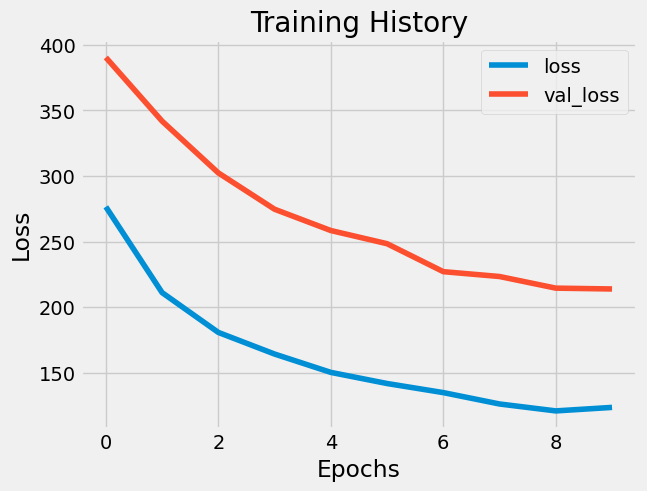

In [29]:
# Plot training history
for name, values in history.history.items():
    plt.plot(values, label=name)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training History")
plt.show()

In [30]:
# Evaluate the model on the test set and save the trained model along with the scaler and configuration.

test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**0.5:.2f}")

# Save the model
try:
    model.save("model.keras")
except Exception as e:
    print(f"Failed to save model: {e}")
else:
    print("Model saved successfully")

# Save the scaler and configuration
import pickle, json
with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)
with open("config.json", "w") as f:
    json.dump(data_config, f)

558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 305.7062
Test RMSE: 14.31
Model saved successfully


In [31]:
# Fetch solar images using the Helioviewer API, process them with OpenCV, and display the results.

# %% [code]
def fetch_solar_image(date_str, source_id=14):
    """
    Fetch a solar image from Helioviewer API for the given ISO date string.
    The source_id parameter can be modified (e.g., 14 for SDO AIA).
    """
    base_url = "https://api.helioviewer.org/v2/getJP2Image/"
    params = {"date": date_str, "sourceId": source_id}
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
    except Exception as e:
        print(f"Error fetching image: {e}")
        return None

    try:
        image = Image.open(BytesIO(response.content))
        image_np = np.array(image)
        return image_np
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

def process_image_with_opencv(image_np):
    """
    Process the image using OpenCV:
    - Convert to grayscale
    - Apply Canny edge detection
    """
    if len(image_np.shape) == 3:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_np.copy()
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    return gray, edges

def display_images(original, processed):
    """
    Display the original and processed images side by side.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap='gray')
    plt.title("Processed Image (Edges)")
    plt.axis("off")
    
    plt.show()

In [35]:
# Example usage: Fetch and process a solar image for a given date/time.
sample_date = "2022-01-01T00:00:00"  # Modify as needed
image_np = fetch_solar_image(sample_date)
if image_np is not None:
    gray_img, edges_img = process_image_with_opencv(image_np)
    display_images(gray_img, edges_img)
else:
    print("Could not fetch image.")

Error fetching image: HTTPSConnectionPool(host='api.helioviewer.org', port=443): Max retries exceeded with url: /v2/getJP2Image/?date=2022-01-01T00%3A00%3A00&sourceId=14 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000002131EF24DA0>, 'Connection to api.helioviewer.org timed out. (connect timeout=None)'))
Could not fetch image.


In [ ]:
# Create a simple dashboard where you can enter a date and see the corresponding solar image and its processed version.

# %% [code]
def on_fetch_button_clicked(b):
 date_str = date_text.value
 print(f"Fetching image for date: {date_str} ...")
image_np = fetch_solar_image(date_str)
if image_np is not None: gray_img, edges_img = process_image_with_opencv(image_np)
display_images(gray_img, edges_img)
    else:
print("Failed to retrieve image. Check the date and try again.")

date_text = widgets.Text(
    value="2022-01-01T00:00:00",
    placeholder="Enter ISO date string (e.g. 2022-01-01T00:00:00)",
    description="Date:",
    disabled=False
)
fetch_button = widgets.Button(description="Fetch Solar Image")
fetch_button.on_click(on_fetch_button_clicked)

dashboard = widgets.VBox([date_text, fetch_button])
display(dashboard)